# **Задание Lite**

Используйте готовый ноутбук с занятия, генерируйте рукописные цифры

Запустите базовую генеративную сеть, с Dense генератором и дискриминатором

Поменяйте размер внутреннего пространства генератора с 100 на 10 и 1000, сравните результаты.

Сделайте свёрточный генератор, сравните результаты с полносвязным генератором

Сделайте возможность запускать обучение с разными batch_size для генератора и дискриминатора, попробуйте запустить с batch_size 128 для дискриминатора и 256 для генератора, сравните результат с равными batch_size по 128.

# Подключение библиотек

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.layers import MaxPooling2D, concatenate, Embedding, multiply, Reshape
from keras.layers import UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist, cifar10
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
from IPython.display import Image
import imageio
import os
import numpy as np

# Подготовка данных

In [ ]:
# Загружаем базу
(xTrain, _), (_, _) = mnist.load_data()

# Нормализуем
xTrain = xTrain / 127.5 - 1.

# Добавляем размерность
xTrain = np.expand_dims(xTrain, axis=3)

In [ ]:
# Задание основных параметров
img_rows = 28                                # Высота изображения
img_cols = 28                                # Ширина
channels = 1                                 # Кол-во каналов(глубина)
img_shape = (img_rows, img_cols, channels)   # Размер входных данных
latent_dim = 100                             # Размер скрытого пространства
batch_size = 128                             # Размер batch_size
optimizer = Adam(0.0002, 0.5)                # Оптимайзер

In [ ]:
# Создание папки для сохранение изображений(визуализация обучения)
!mkdir images

# Создание необходимых функций

In [ ]:
# Функция печати изображений
def sample_images(epoch, gen, latent_dim=100):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, latent_dim))  # (25,100)
  gen_imgs = gen.predict(noise)

  fig, axs = plt.subplots(r, c)
  cnt = 0 
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()
  fig.savefig("images/%d.png" % epoch)
  plt.close()

In [ ]:
# Функция создания генератора
def create_generator(latent_dim=100):
  generator = Sequential()

  generator.add(Dense(256, input_dim=latent_dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Dense(512))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Dense(1024))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Dense(np.prod(img_shape), activation='tanh'))
  generator.add(Reshape(img_shape))

  noise = Input(shape=(latent_dim,))
  img = generator(noise)

  generator = Model(noise, img)

  return generator 

In [ ]:
 # Функция создания дискриминатора
 def create_discriminator():
   discriminator = Sequential()
   discriminator.add(Flatten(input_shape=img_shape))

   discriminator.add(Dense(512))
   discriminator.add(LeakyReLU(alpha=0.2))

   discriminator.add(Dense(256))
   discriminator.add(LeakyReLU(alpha=0.2))

   discriminator.add(Dense(1, activation='sigmoid'))

   img = Input(shape=img_shape)
   validity = discriminator(img)

   discriminator = Model(img, validity)

   discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

   discriminator.trainable = False

   return discriminator

In [ ]:
# Функция обучения
def train(generator, discriminator, latent_dim=100, epochs=30000, batch_size=128):
  # Создаем массив единиц и нулей длинной batch_size
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  z = Input(shape=(latent_dim,))
  img = generator(z)
  validity = discriminator(img)

  # Создаем полную сеть
  combine = Model(z, validity)
  combine.compile(loss='binary_crossentropy', optimizer=optimizer)

  sample_interval = 200

  # Создадим массивы значений
  d_loss_list = []  # ошибки дескриминатора
  g_loss_list = []  # ошибки генератора  
  d_acc_list = []   # значений точности модели

  for epoch in range(epochs):

    # Train Discriminator

    # Создаем массив случайных значений
    idx = np.random.randint(0, xTrain.shape[0], batch_size)
    imgs = xTrain[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    gen_imgs = generator.predict(noise)

    # Train 

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #  Train Generator

    g_loss = combine.train_on_batch(noise, valid) # Получаем ошибку генератора
    #print(combine.metrics_names)

    # Печатаем номер эпохи и значения ошибок на этой эпохе
    print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss)
    d_acc_list.append(100*d_loss[1])

    if ((epoch % sample_interval == 0) | (epoch == epoch - 1)):
      # Вызываем функцию sample_images
      sample_images(epoch, generator, latent_dim)


  # Выводим графики
  plt.plot(d_loss_list, label='Ошибка дискриминатора')
  plt.plot(g_loss_list, label='Ошибка генератора')
  plt.legend()
  plt.show()

  plt.plot(d_acc_list, label='Тосность дискриминатора')
  plt.legend()
  plt.show()

# Размер внутреннего пространства генератора **100**, **10** и **1000**

Поменяйте размер внутреннего пространства генератора с 100 на 10 и 1000, сравните результаты.

## latent_dim - **100**

In [ ]:
generator = create_generator(100)
discriminator = create_discriminator()
train(generator, discriminator , 100, 10000)

## latent_dim - **10**

In [ ]:
generator = create_generator(10)
discriminator = create_discriminator()
train(generator, discriminator , 10, 10000)

## latent_dim - **1000**

In [ ]:
generator = create_generator(1000)
discriminator = create_discriminator()
train(generator, discriminator , 1000, 10000)

# Свёрточный генератор

Сделайте свёрточный генератор, сравните результаты с полносвязным генератором.

In [ ]:
# Создадим сверточный генератор
def create_conv_generator(latent_dim=100):
  generator = Sequential()

  
  generator.add(Dense(28*28, input_dim=latent_dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Reshape(img_shape))

  generator.add(Conv2D(16, (3,3), padding='same'))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Conv2D(32, (3,3), padding='same'))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Conv2D(64, (3,3), padding='same'))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(Flatten())

  generator.add(Dense(np.prod(img_shape), activation='tanh'))
  generator.add(Reshape(img_shape))

  noise = Input(shape=(latent_dim,))
  img = generator(noise)

  generator = Model(noise, img)

  return generator 

## latent_dim - **100**

In [ ]:
generator = create_conv_generator(100)
discriminator = create_discriminator()
train(generator, discriminator , 100, 10000)

## latent_dim - **10**

0 [D loss: 0.850397, acc: 8.98%] [G loss: 0.181805]


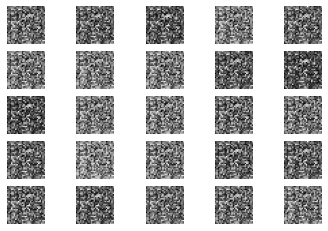

1 [D loss: 5.049585, acc: 53.91%] [G loss: 3.933721]
2 [D loss: 3.754806, acc: 50.00%] [G loss: 11.664052]
3 [D loss: 13.763748, acc: 0.00%] [G loss: 0.074430]
4 [D loss: 0.100697, acc: 97.66%] [G loss: 0.053109]
5 [D loss: 0.013280, acc: 100.00%] [G loss: 0.041487]
6 [D loss: 0.018987, acc: 100.00%] [G loss: 0.022559]
7 [D loss: 0.042816, acc: 99.61%] [G loss: 0.029880]
8 [D loss: 0.079692, acc: 98.05%] [G loss: 0.047010]
9 [D loss: 0.041418, acc: 99.61%] [G loss: 0.078786]
10 [D loss: 0.089685, acc: 98.44%] [G loss: 0.114265]
11 [D loss: 0.122540, acc: 96.88%] [G loss: 0.126193]
12 [D loss: 0.201238, acc: 92.58%] [G loss: 0.252441]
13 [D loss: 0.620177, acc: 73.05%] [G loss: 0.688687]
14 [D loss: 1.563494, acc: 44.53%] [G loss: 0.809867]
15 [D loss: 0.461136, acc: 78.52%] [G loss: 3.056509]
16 [D loss: 2.361076, acc: 15.23%] [G loss: 2.095148]
17 [D loss: 0.999399, acc: 62.89%] [G loss: 3.708093]
18 [D loss: 0.091464, acc: 96.88%] [G loss: 4.752445]
19 [D loss: 0.341966, acc: 87.89%]

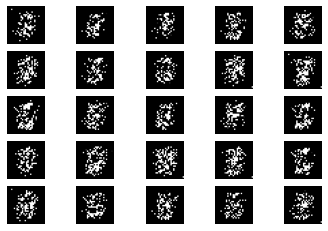

201 [D loss: 0.528119, acc: 85.16%] [G loss: 1.874953]
202 [D loss: 0.527506, acc: 83.98%] [G loss: 1.833527]
203 [D loss: 0.522924, acc: 88.28%] [G loss: 1.847980]
204 [D loss: 0.553321, acc: 83.59%] [G loss: 1.785473]
205 [D loss: 0.514188, acc: 87.50%] [G loss: 1.933499]
206 [D loss: 0.529891, acc: 84.77%] [G loss: 1.838864]
207 [D loss: 0.525326, acc: 86.72%] [G loss: 1.805158]
208 [D loss: 0.518958, acc: 86.33%] [G loss: 1.863754]
209 [D loss: 0.563887, acc: 79.30%] [G loss: 1.849792]
210 [D loss: 0.529025, acc: 84.77%] [G loss: 1.925961]
211 [D loss: 0.560121, acc: 79.30%] [G loss: 1.845725]
212 [D loss: 0.552217, acc: 81.25%] [G loss: 1.859523]
213 [D loss: 0.559723, acc: 81.64%] [G loss: 1.890507]
214 [D loss: 0.549215, acc: 80.08%] [G loss: 1.932350]
215 [D loss: 0.552794, acc: 81.64%] [G loss: 1.833638]
216 [D loss: 0.537161, acc: 84.77%] [G loss: 1.916312]
217 [D loss: 0.571724, acc: 76.95%] [G loss: 1.830454]
218 [D loss: 0.512753, acc: 85.16%] [G loss: 1.930538]
219 [D los

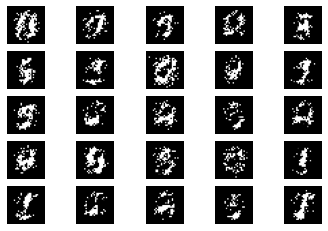

401 [D loss: 0.492148, acc: 83.20%] [G loss: 2.320439]
402 [D loss: 0.451574, acc: 87.50%] [G loss: 2.550722]
403 [D loss: 0.482516, acc: 83.59%] [G loss: 2.422994]
404 [D loss: 0.510546, acc: 81.64%] [G loss: 2.439324]
405 [D loss: 0.466072, acc: 85.94%] [G loss: 2.439492]
406 [D loss: 0.465943, acc: 83.59%] [G loss: 2.460991]
407 [D loss: 0.456500, acc: 87.50%] [G loss: 2.478635]
408 [D loss: 0.576081, acc: 70.70%] [G loss: 2.311380]
409 [D loss: 0.491987, acc: 84.77%] [G loss: 2.410441]
410 [D loss: 0.462034, acc: 84.38%] [G loss: 2.411604]
411 [D loss: 0.490338, acc: 83.98%] [G loss: 2.348907]
412 [D loss: 0.442405, acc: 88.67%] [G loss: 2.528462]
413 [D loss: 0.516379, acc: 79.30%] [G loss: 2.316832]
414 [D loss: 0.400033, acc: 93.36%] [G loss: 2.656219]
415 [D loss: 0.526071, acc: 77.73%] [G loss: 2.388371]
416 [D loss: 0.484730, acc: 81.64%] [G loss: 2.496016]
417 [D loss: 0.501603, acc: 78.91%] [G loss: 2.410357]
418 [D loss: 0.454041, acc: 87.11%] [G loss: 2.561437]
419 [D los

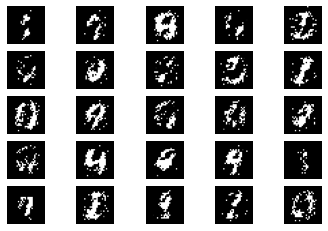

601 [D loss: 0.261792, acc: 96.09%] [G loss: 3.914994]
602 [D loss: 0.302346, acc: 92.19%] [G loss: 3.726156]
603 [D loss: 0.294122, acc: 94.53%] [G loss: 3.938205]
604 [D loss: 0.399138, acc: 83.59%] [G loss: 4.322349]
605 [D loss: 0.392386, acc: 87.11%] [G loss: 3.657782]
606 [D loss: 0.354967, acc: 87.50%] [G loss: 3.908547]
607 [D loss: 0.294641, acc: 92.58%] [G loss: 3.433683]
608 [D loss: 0.216413, acc: 97.27%] [G loss: 3.803340]
609 [D loss: 0.290652, acc: 94.53%] [G loss: 3.773075]
610 [D loss: 0.282375, acc: 93.36%] [G loss: 3.852054]
611 [D loss: 0.408812, acc: 85.16%] [G loss: 4.313881]
612 [D loss: 0.492428, acc: 77.73%] [G loss: 4.259356]
613 [D loss: 0.419349, acc: 84.77%] [G loss: 3.474885]
614 [D loss: 0.281897, acc: 93.75%] [G loss: 3.849562]
615 [D loss: 0.275648, acc: 93.75%] [G loss: 3.376739]
616 [D loss: 0.215751, acc: 98.44%] [G loss: 3.713617]
617 [D loss: 0.284980, acc: 93.36%] [G loss: 3.866659]
618 [D loss: 0.340759, acc: 91.41%] [G loss: 3.675267]
619 [D los

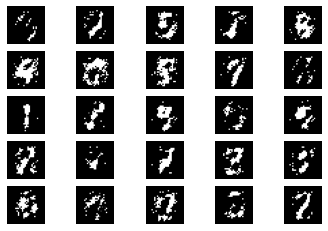

801 [D loss: 0.333246, acc: 83.98%] [G loss: 3.633271]
802 [D loss: 0.270190, acc: 93.36%] [G loss: 3.467707]
803 [D loss: 0.160693, acc: 98.83%] [G loss: 3.644194]
804 [D loss: 0.174836, acc: 98.44%] [G loss: 3.640075]
805 [D loss: 0.196699, acc: 97.27%] [G loss: 3.877601]
806 [D loss: 0.281963, acc: 92.97%] [G loss: 3.725331]
807 [D loss: 0.169454, acc: 97.66%] [G loss: 3.965156]
808 [D loss: 0.212154, acc: 97.27%] [G loss: 3.910364]
809 [D loss: 0.230521, acc: 95.70%] [G loss: 4.088255]
810 [D loss: 0.229277, acc: 93.75%] [G loss: 3.581223]
811 [D loss: 0.240036, acc: 95.70%] [G loss: 4.727313]
812 [D loss: 0.496905, acc: 76.56%] [G loss: 5.135086]
813 [D loss: 0.464868, acc: 79.30%] [G loss: 4.263809]
814 [D loss: 0.179495, acc: 94.53%] [G loss: 3.686451]
815 [D loss: 0.260321, acc: 94.92%] [G loss: 4.527805]
816 [D loss: 0.214883, acc: 94.92%] [G loss: 3.561947]
817 [D loss: 0.200446, acc: 97.66%] [G loss: 4.578293]
818 [D loss: 0.386559, acc: 86.72%] [G loss: 5.202986]
819 [D los

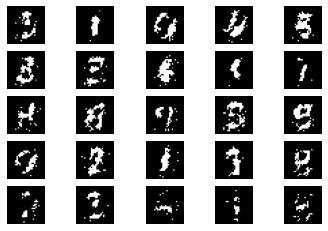

1001 [D loss: 0.076154, acc: 100.00%] [G loss: 4.575714]
1002 [D loss: 0.114995, acc: 99.22%] [G loss: 4.701969]
1003 [D loss: 0.143946, acc: 98.44%] [G loss: 4.974051]
1004 [D loss: 0.115723, acc: 97.66%] [G loss: 4.209474]
1005 [D loss: 0.083518, acc: 100.00%] [G loss: 4.826688]
1006 [D loss: 0.138209, acc: 97.66%] [G loss: 4.744499]
1007 [D loss: 0.093729, acc: 98.83%] [G loss: 4.399730]
1008 [D loss: 0.112420, acc: 97.66%] [G loss: 4.832216]
1009 [D loss: 0.091357, acc: 98.83%] [G loss: 4.513825]
1010 [D loss: 0.065199, acc: 100.00%] [G loss: 4.705510]
1011 [D loss: 0.072266, acc: 99.22%] [G loss: 4.335690]
1012 [D loss: 0.083136, acc: 99.22%] [G loss: 4.900135]
1013 [D loss: 0.089135, acc: 99.22%] [G loss: 4.285781]
1014 [D loss: 0.065570, acc: 99.61%] [G loss: 4.624847]
1015 [D loss: 0.091957, acc: 99.22%] [G loss: 4.575763]
1016 [D loss: 0.061744, acc: 99.61%] [G loss: 4.405838]
1017 [D loss: 0.094557, acc: 99.61%] [G loss: 5.249858]
1018 [D loss: 0.097125, acc: 98.83%] [G loss:

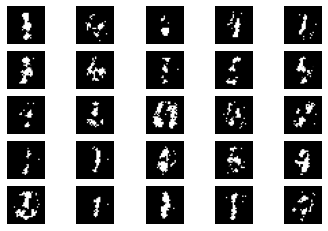

1201 [D loss: 0.133441, acc: 97.66%] [G loss: 4.317805]
1202 [D loss: 0.099362, acc: 98.44%] [G loss: 5.198532]
1203 [D loss: 0.090171, acc: 98.05%] [G loss: 4.494175]
1204 [D loss: 0.101370, acc: 98.83%] [G loss: 4.706367]
1205 [D loss: 0.075933, acc: 98.83%] [G loss: 4.454191]
1206 [D loss: 0.069481, acc: 99.61%] [G loss: 4.876009]
1207 [D loss: 0.087930, acc: 98.83%] [G loss: 4.701216]
1208 [D loss: 0.111022, acc: 98.83%] [G loss: 5.148082]
1209 [D loss: 0.103040, acc: 98.83%] [G loss: 4.709142]
1210 [D loss: 0.059594, acc: 100.00%] [G loss: 4.642766]
1211 [D loss: 0.073141, acc: 99.22%] [G loss: 4.570504]
1212 [D loss: 0.099723, acc: 98.44%] [G loss: 5.000063]
1213 [D loss: 0.079833, acc: 99.22%] [G loss: 4.582567]
1214 [D loss: 0.074295, acc: 99.61%] [G loss: 4.815834]
1215 [D loss: 0.135756, acc: 98.44%] [G loss: 6.054401]
1216 [D loss: 0.200828, acc: 94.92%] [G loss: 5.478625]
1217 [D loss: 0.102161, acc: 97.66%] [G loss: 4.416310]
1218 [D loss: 0.099218, acc: 98.44%] [G loss: 5

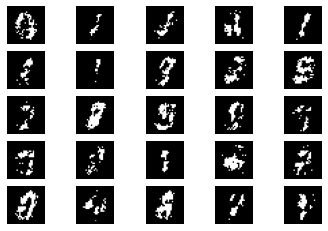

1401 [D loss: 0.082814, acc: 98.83%] [G loss: 5.354529]
1402 [D loss: 0.061350, acc: 99.61%] [G loss: 4.987918]
1403 [D loss: 0.042659, acc: 99.61%] [G loss: 4.876098]
1404 [D loss: 0.070663, acc: 99.61%] [G loss: 5.416623]
1405 [D loss: 0.087704, acc: 99.22%] [G loss: 5.101493]
1406 [D loss: 0.032609, acc: 100.00%] [G loss: 5.183678]
1407 [D loss: 0.074715, acc: 99.22%] [G loss: 4.848420]
1408 [D loss: 0.033666, acc: 100.00%] [G loss: 5.032733]
1409 [D loss: 0.055381, acc: 98.83%] [G loss: 4.886410]
1410 [D loss: 0.049647, acc: 100.00%] [G loss: 4.942290]
1411 [D loss: 0.055642, acc: 100.00%] [G loss: 5.148489]
1412 [D loss: 0.046561, acc: 100.00%] [G loss: 4.638122]
1413 [D loss: 0.065624, acc: 98.44%] [G loss: 5.541624]
1414 [D loss: 0.057666, acc: 99.22%] [G loss: 4.723961]
1415 [D loss: 0.076170, acc: 99.22%] [G loss: 5.759885]
1416 [D loss: 0.099916, acc: 99.61%] [G loss: 4.807177]
1417 [D loss: 0.049641, acc: 100.00%] [G loss: 5.220850]
1418 [D loss: 0.076488, acc: 99.22%] [G lo

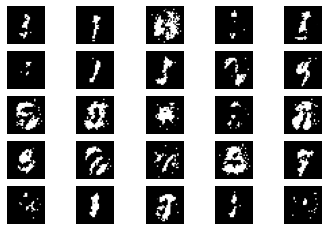

1601 [D loss: 0.124696, acc: 98.05%] [G loss: 4.268091]
1602 [D loss: 0.096137, acc: 98.44%] [G loss: 4.316926]
1603 [D loss: 0.108945, acc: 98.44%] [G loss: 4.098766]
1604 [D loss: 0.073156, acc: 99.61%] [G loss: 4.574075]
1605 [D loss: 0.116688, acc: 98.44%] [G loss: 4.218576]
1606 [D loss: 0.131326, acc: 98.44%] [G loss: 4.349505]
1607 [D loss: 0.083420, acc: 99.22%] [G loss: 4.250298]
1608 [D loss: 0.111185, acc: 98.05%] [G loss: 4.433763]
1609 [D loss: 0.100889, acc: 98.83%] [G loss: 4.151986]
1610 [D loss: 0.093694, acc: 98.83%] [G loss: 4.326773]
1611 [D loss: 0.087774, acc: 98.83%] [G loss: 4.365550]
1612 [D loss: 0.102710, acc: 98.83%] [G loss: 4.212331]
1613 [D loss: 0.086103, acc: 99.61%] [G loss: 4.482724]
1614 [D loss: 0.096904, acc: 98.05%] [G loss: 4.254534]
1615 [D loss: 0.119229, acc: 98.05%] [G loss: 4.804651]
1616 [D loss: 0.084127, acc: 98.83%] [G loss: 4.379567]
1617 [D loss: 0.092065, acc: 98.44%] [G loss: 4.429960]
1618 [D loss: 0.079664, acc: 99.22%] [G loss: 4.

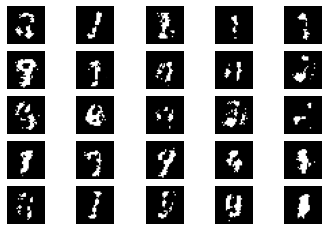

1801 [D loss: 0.089962, acc: 98.83%] [G loss: 4.737638]
1802 [D loss: 0.089124, acc: 98.05%] [G loss: 4.914447]
1803 [D loss: 0.069859, acc: 98.83%] [G loss: 4.310600]
1804 [D loss: 0.073422, acc: 99.61%] [G loss: 4.913487]
1805 [D loss: 0.080781, acc: 99.22%] [G loss: 4.769439]
1806 [D loss: 0.067360, acc: 99.22%] [G loss: 4.778128]
1807 [D loss: 0.094170, acc: 98.83%] [G loss: 5.198407]
1808 [D loss: 0.058680, acc: 98.83%] [G loss: 4.689084]
1809 [D loss: 0.097930, acc: 98.83%] [G loss: 5.555067]
1810 [D loss: 0.073101, acc: 98.83%] [G loss: 4.563491]
1811 [D loss: 0.103011, acc: 98.83%] [G loss: 5.906073]
1812 [D loss: 0.078562, acc: 99.61%] [G loss: 4.433945]
1813 [D loss: 0.059791, acc: 100.00%] [G loss: 5.463467]
1814 [D loss: 0.119297, acc: 98.05%] [G loss: 5.383849]
1815 [D loss: 0.066500, acc: 99.22%] [G loss: 4.713709]
1816 [D loss: 0.063599, acc: 99.61%] [G loss: 5.362244]
1817 [D loss: 0.057949, acc: 99.22%] [G loss: 4.757835]
1818 [D loss: 0.037451, acc: 100.00%] [G loss: 

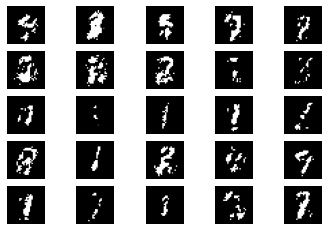

2001 [D loss: 0.040126, acc: 100.00%] [G loss: 5.247560]
2002 [D loss: 0.038367, acc: 100.00%] [G loss: 5.411385]
2003 [D loss: 0.042371, acc: 99.61%] [G loss: 5.270136]
2004 [D loss: 0.041915, acc: 99.61%] [G loss: 5.804680]
2005 [D loss: 0.051271, acc: 99.61%] [G loss: 5.584329]
2006 [D loss: 0.032812, acc: 99.61%] [G loss: 5.584627]
2007 [D loss: 0.037978, acc: 100.00%] [G loss: 5.290487]
2008 [D loss: 0.028390, acc: 99.61%] [G loss: 5.614730]
2009 [D loss: 0.040100, acc: 99.22%] [G loss: 5.334940]
2010 [D loss: 0.036943, acc: 100.00%] [G loss: 5.341488]
2011 [D loss: 0.023809, acc: 100.00%] [G loss: 5.733954]
2012 [D loss: 0.038503, acc: 99.22%] [G loss: 5.340569]
2013 [D loss: 0.027101, acc: 100.00%] [G loss: 5.240910]
2014 [D loss: 0.027272, acc: 100.00%] [G loss: 5.555333]
2015 [D loss: 0.054287, acc: 99.22%] [G loss: 6.125578]
2016 [D loss: 0.085696, acc: 98.44%] [G loss: 5.483755]
2017 [D loss: 0.035065, acc: 99.61%] [G loss: 5.481006]
2018 [D loss: 0.038015, acc: 99.61%] [G l

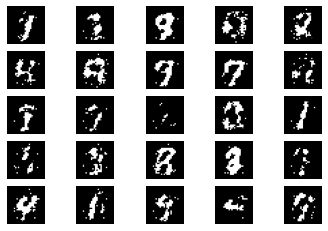

2201 [D loss: 0.043630, acc: 100.00%] [G loss: 5.177844]
2202 [D loss: 0.039617, acc: 99.61%] [G loss: 5.200721]
2203 [D loss: 0.045765, acc: 99.61%] [G loss: 5.056525]
2204 [D loss: 0.038002, acc: 100.00%] [G loss: 5.223902]
2205 [D loss: 0.035247, acc: 100.00%] [G loss: 5.187243]
2206 [D loss: 0.037928, acc: 100.00%] [G loss: 4.983882]
2207 [D loss: 0.040487, acc: 100.00%] [G loss: 4.919834]
2208 [D loss: 0.033571, acc: 100.00%] [G loss: 5.216099]
2209 [D loss: 0.033111, acc: 100.00%] [G loss: 5.075661]
2210 [D loss: 0.045288, acc: 99.22%] [G loss: 5.274258]
2211 [D loss: 0.046822, acc: 99.61%] [G loss: 5.425471]
2212 [D loss: 0.037318, acc: 100.00%] [G loss: 5.256099]
2213 [D loss: 0.062684, acc: 99.22%] [G loss: 5.728995]
2214 [D loss: 0.047116, acc: 100.00%] [G loss: 5.022564]
2215 [D loss: 0.033522, acc: 100.00%] [G loss: 5.753023]
2216 [D loss: 0.041678, acc: 99.61%] [G loss: 5.246015]
2217 [D loss: 0.045698, acc: 99.61%] [G loss: 5.366005]
2218 [D loss: 0.027909, acc: 100.00%] 

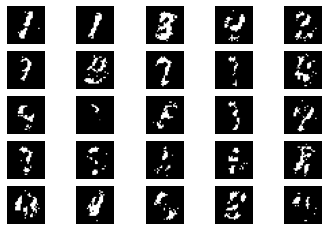

2401 [D loss: 0.071725, acc: 99.22%] [G loss: 4.832771]
2402 [D loss: 0.046574, acc: 100.00%] [G loss: 4.817846]
2403 [D loss: 0.058026, acc: 99.61%] [G loss: 4.909328]
2404 [D loss: 0.056194, acc: 99.61%] [G loss: 5.050366]
2405 [D loss: 0.083498, acc: 99.22%] [G loss: 5.210874]
2406 [D loss: 0.073344, acc: 99.61%] [G loss: 4.863882]
2407 [D loss: 0.054617, acc: 99.61%] [G loss: 5.285445]
2408 [D loss: 0.054080, acc: 100.00%] [G loss: 4.951213]
2409 [D loss: 0.063512, acc: 99.61%] [G loss: 4.899504]
2410 [D loss: 0.073228, acc: 99.61%] [G loss: 5.118358]
2411 [D loss: 0.050561, acc: 100.00%] [G loss: 4.808018]
2412 [D loss: 0.075496, acc: 100.00%] [G loss: 5.342891]
2413 [D loss: 0.061667, acc: 99.22%] [G loss: 4.948724]
2414 [D loss: 0.086160, acc: 98.83%] [G loss: 5.203513]
2415 [D loss: 0.073402, acc: 99.22%] [G loss: 5.049685]
2416 [D loss: 0.116422, acc: 98.44%] [G loss: 6.233718]
2417 [D loss: 0.106791, acc: 97.66%] [G loss: 4.079891]
2418 [D loss: 0.051987, acc: 98.83%] [G loss

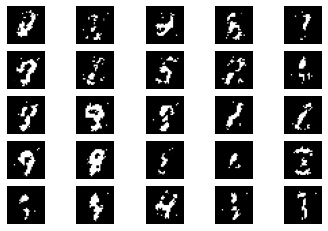

2601 [D loss: 0.042765, acc: 100.00%] [G loss: 5.376623]
2602 [D loss: 0.043634, acc: 100.00%] [G loss: 5.477901]
2603 [D loss: 0.059512, acc: 99.22%] [G loss: 5.346419]
2604 [D loss: 0.026449, acc: 100.00%] [G loss: 5.640715]
2605 [D loss: 0.042296, acc: 99.61%] [G loss: 5.599775]
2606 [D loss: 0.068839, acc: 99.61%] [G loss: 5.807141]
2607 [D loss: 0.058193, acc: 98.44%] [G loss: 4.983981]
2608 [D loss: 0.041493, acc: 99.22%] [G loss: 5.518378]
2609 [D loss: 0.039471, acc: 99.61%] [G loss: 5.734984]
2610 [D loss: 0.031628, acc: 100.00%] [G loss: 5.453726]
2611 [D loss: 0.044513, acc: 100.00%] [G loss: 5.840288]
2612 [D loss: 0.029054, acc: 99.61%] [G loss: 5.376967]
2613 [D loss: 0.032260, acc: 100.00%] [G loss: 5.819051]
2614 [D loss: 0.042170, acc: 99.22%] [G loss: 5.224071]
2615 [D loss: 0.027664, acc: 100.00%] [G loss: 5.490950]
2616 [D loss: 0.027131, acc: 100.00%] [G loss: 5.858799]
2617 [D loss: 0.060778, acc: 99.61%] [G loss: 5.842335]
2618 [D loss: 0.046699, acc: 98.83%] [G 

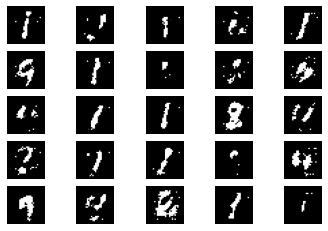

2801 [D loss: 0.182940, acc: 95.31%] [G loss: 4.351082]
2802 [D loss: 0.103116, acc: 98.05%] [G loss: 4.646999]
2803 [D loss: 0.196279, acc: 96.48%] [G loss: 4.770225]
2804 [D loss: 0.187456, acc: 96.48%] [G loss: 4.444304]
2805 [D loss: 0.142813, acc: 97.27%] [G loss: 4.948316]
2806 [D loss: 0.120687, acc: 98.83%] [G loss: 4.230171]
2807 [D loss: 0.142309, acc: 98.05%] [G loss: 5.125190]
2808 [D loss: 0.089850, acc: 98.05%] [G loss: 4.371964]
2809 [D loss: 0.130743, acc: 98.83%] [G loss: 5.128333]
2810 [D loss: 0.123855, acc: 97.66%] [G loss: 4.375237]
2811 [D loss: 0.095853, acc: 98.83%] [G loss: 4.789867]
2812 [D loss: 0.103808, acc: 98.44%] [G loss: 4.592047]
2813 [D loss: 0.145505, acc: 96.48%] [G loss: 5.281193]
2814 [D loss: 0.134105, acc: 96.48%] [G loss: 4.870218]
2815 [D loss: 0.135907, acc: 98.83%] [G loss: 4.973572]
2816 [D loss: 0.149896, acc: 98.83%] [G loss: 5.103629]
2817 [D loss: 0.183333, acc: 94.92%] [G loss: 5.533103]
2818 [D loss: 0.128256, acc: 98.83%] [G loss: 4.

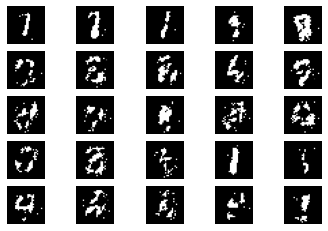

3001 [D loss: 0.048161, acc: 99.61%] [G loss: 4.918902]
3002 [D loss: 0.032382, acc: 100.00%] [G loss: 5.334924]
3003 [D loss: 0.051851, acc: 99.61%] [G loss: 4.953520]
3004 [D loss: 0.042445, acc: 100.00%] [G loss: 5.354271]
3005 [D loss: 0.044274, acc: 99.22%] [G loss: 5.584151]
3006 [D loss: 0.036955, acc: 100.00%] [G loss: 4.999768]
3007 [D loss: 0.043418, acc: 100.00%] [G loss: 5.318241]
3008 [D loss: 0.045389, acc: 99.61%] [G loss: 5.140023]
3009 [D loss: 0.049532, acc: 99.61%] [G loss: 5.442934]
3010 [D loss: 0.047097, acc: 100.00%] [G loss: 5.436378]
3011 [D loss: 0.051152, acc: 100.00%] [G loss: 5.639584]
3012 [D loss: 0.027539, acc: 100.00%] [G loss: 5.295396]
3013 [D loss: 0.051660, acc: 100.00%] [G loss: 5.431129]
3014 [D loss: 0.042464, acc: 99.22%] [G loss: 5.384125]
3015 [D loss: 0.057282, acc: 99.61%] [G loss: 5.992702]
3016 [D loss: 0.077317, acc: 99.22%] [G loss: 5.459634]
3017 [D loss: 0.045102, acc: 99.22%] [G loss: 5.270302]
3018 [D loss: 0.042792, acc: 100.00%] [G

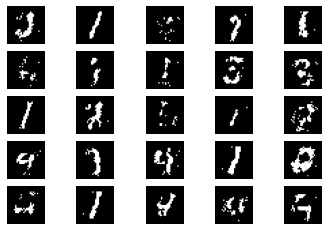

3201 [D loss: 0.070855, acc: 99.22%] [G loss: 5.232639]
3202 [D loss: 0.043569, acc: 99.22%] [G loss: 4.927520]
3203 [D loss: 0.059845, acc: 99.61%] [G loss: 5.531241]
3204 [D loss: 0.114325, acc: 98.83%] [G loss: 6.158846]
3205 [D loss: 0.055003, acc: 98.83%] [G loss: 5.014673]
3206 [D loss: 0.070142, acc: 98.83%] [G loss: 5.762378]
3207 [D loss: 0.049896, acc: 100.00%] [G loss: 4.905299]
3208 [D loss: 0.043871, acc: 100.00%] [G loss: 5.160648]
3209 [D loss: 0.048873, acc: 99.22%] [G loss: 5.202640]
3210 [D loss: 0.068064, acc: 100.00%] [G loss: 5.712103]
3211 [D loss: 0.034694, acc: 100.00%] [G loss: 5.472946]
3212 [D loss: 0.079300, acc: 99.22%] [G loss: 5.721275]
3213 [D loss: 0.067739, acc: 99.22%] [G loss: 5.582452]
3214 [D loss: 0.065100, acc: 98.83%] [G loss: 5.075167]
3215 [D loss: 0.041338, acc: 100.00%] [G loss: 5.284992]
3216 [D loss: 0.044070, acc: 100.00%] [G loss: 5.538704]
3217 [D loss: 0.049756, acc: 100.00%] [G loss: 5.157956]
3218 [D loss: 0.051614, acc: 99.61%] [G l

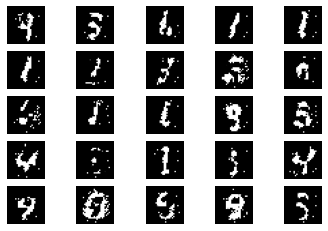

3401 [D loss: 0.022086, acc: 100.00%] [G loss: 5.537282]
3402 [D loss: 0.046104, acc: 99.61%] [G loss: 6.252257]
3403 [D loss: 0.025131, acc: 100.00%] [G loss: 5.307427]
3404 [D loss: 0.023338, acc: 100.00%] [G loss: 5.355247]
3405 [D loss: 0.031919, acc: 99.61%] [G loss: 5.511720]
3406 [D loss: 0.025273, acc: 100.00%] [G loss: 5.779613]
3407 [D loss: 0.053202, acc: 99.61%] [G loss: 6.542209]
3408 [D loss: 0.036706, acc: 99.61%] [G loss: 5.544695]
3409 [D loss: 0.028024, acc: 99.61%] [G loss: 5.730608]
3410 [D loss: 0.020146, acc: 100.00%] [G loss: 5.781245]
3411 [D loss: 0.029386, acc: 100.00%] [G loss: 5.929561]
3412 [D loss: 0.023425, acc: 99.61%] [G loss: 5.687277]
3413 [D loss: 0.022787, acc: 100.00%] [G loss: 5.392718]
3414 [D loss: 0.021012, acc: 100.00%] [G loss: 5.883917]
3415 [D loss: 0.046826, acc: 98.83%] [G loss: 5.779280]
3416 [D loss: 0.031154, acc: 100.00%] [G loss: 5.951214]
3417 [D loss: 0.019369, acc: 99.61%] [G loss: 5.593904]
3418 [D loss: 0.015872, acc: 100.00%] [

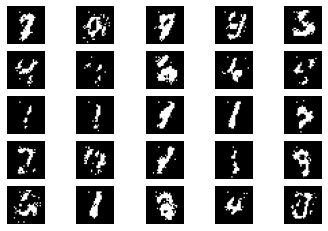

3601 [D loss: 0.059258, acc: 100.00%] [G loss: 4.823281]
3602 [D loss: 0.100209, acc: 98.83%] [G loss: 4.826100]
3603 [D loss: 0.094678, acc: 99.22%] [G loss: 5.153096]
3604 [D loss: 0.087813, acc: 99.61%] [G loss: 4.615893]
3605 [D loss: 0.074781, acc: 99.61%] [G loss: 4.781921]
3606 [D loss: 0.064398, acc: 100.00%] [G loss: 4.608725]
3607 [D loss: 0.142049, acc: 96.88%] [G loss: 5.792148]
3608 [D loss: 0.099338, acc: 98.83%] [G loss: 4.301194]
3609 [D loss: 0.068053, acc: 99.61%] [G loss: 4.946170]
3610 [D loss: 0.071619, acc: 99.61%] [G loss: 4.624286]
3611 [D loss: 0.053728, acc: 100.00%] [G loss: 4.995466]
3612 [D loss: 0.084012, acc: 98.44%] [G loss: 4.746926]
3613 [D loss: 0.060261, acc: 100.00%] [G loss: 5.111935]
3614 [D loss: 0.063299, acc: 100.00%] [G loss: 4.831009]
3615 [D loss: 0.075351, acc: 99.61%] [G loss: 4.894243]
3616 [D loss: 0.080443, acc: 99.61%] [G loss: 4.353629]
3617 [D loss: 0.063492, acc: 99.22%] [G loss: 5.090796]
3618 [D loss: 0.058662, acc: 99.61%] [G los

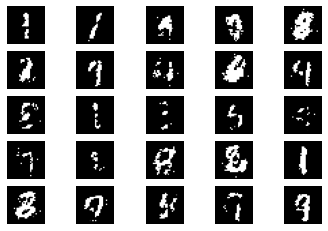

3801 [D loss: 0.036778, acc: 99.61%] [G loss: 5.683425]
3802 [D loss: 0.030896, acc: 99.61%] [G loss: 5.776290]
3803 [D loss: 0.040131, acc: 100.00%] [G loss: 5.318231]
3804 [D loss: 0.037371, acc: 100.00%] [G loss: 5.311557]
3805 [D loss: 0.043283, acc: 99.22%] [G loss: 5.831491]
3806 [D loss: 0.053055, acc: 99.22%] [G loss: 5.513700]
3807 [D loss: 0.018368, acc: 100.00%] [G loss: 5.756129]
3808 [D loss: 0.075898, acc: 98.05%] [G loss: 6.315355]
3809 [D loss: 0.038807, acc: 100.00%] [G loss: 5.258697]
3810 [D loss: 0.041452, acc: 100.00%] [G loss: 6.048951]
3811 [D loss: 0.021858, acc: 100.00%] [G loss: 5.701625]
3812 [D loss: 0.069369, acc: 99.22%] [G loss: 6.416158]
3813 [D loss: 0.054449, acc: 98.83%] [G loss: 5.178584]
3814 [D loss: 0.046118, acc: 99.61%] [G loss: 5.408767]
3815 [D loss: 0.032157, acc: 100.00%] [G loss: 5.751906]
3816 [D loss: 0.072463, acc: 99.61%] [G loss: 6.137927]
3817 [D loss: 0.026664, acc: 100.00%] [G loss: 5.744523]
3818 [D loss: 0.042802, acc: 99.61%] [G 

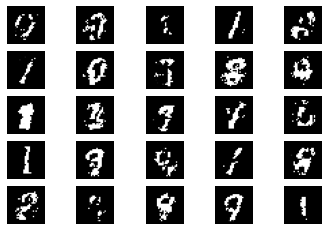

4001 [D loss: 0.053926, acc: 100.00%] [G loss: 5.391254]
4002 [D loss: 0.073389, acc: 98.44%] [G loss: 5.317390]
4003 [D loss: 0.048796, acc: 99.61%] [G loss: 5.145824]
4004 [D loss: 0.057554, acc: 99.61%] [G loss: 5.602211]
4005 [D loss: 0.064455, acc: 99.61%] [G loss: 5.097758]
4006 [D loss: 0.078011, acc: 99.22%] [G loss: 5.852394]
4007 [D loss: 0.089979, acc: 99.22%] [G loss: 5.657504]
4008 [D loss: 0.046017, acc: 99.61%] [G loss: 5.067715]
4009 [D loss: 0.039307, acc: 100.00%] [G loss: 5.553788]
4010 [D loss: 0.062801, acc: 99.22%] [G loss: 5.210128]
4011 [D loss: 0.046020, acc: 100.00%] [G loss: 5.503161]
4012 [D loss: 0.097912, acc: 98.05%] [G loss: 6.948534]
4013 [D loss: 0.068775, acc: 98.83%] [G loss: 4.598797]
4014 [D loss: 0.046073, acc: 100.00%] [G loss: 6.150170]
4015 [D loss: 0.091241, acc: 97.66%] [G loss: 5.231915]
4016 [D loss: 0.049650, acc: 99.22%] [G loss: 5.448477]
4017 [D loss: 0.037548, acc: 99.61%] [G loss: 5.374148]
4018 [D loss: 0.046303, acc: 99.61%] [G loss

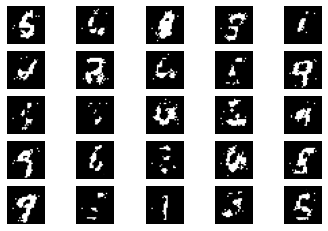

4201 [D loss: 0.048460, acc: 100.00%] [G loss: 5.750549]
4202 [D loss: 0.038168, acc: 99.61%] [G loss: 5.101946]
4203 [D loss: 0.043328, acc: 99.22%] [G loss: 5.620755]
4204 [D loss: 0.023237, acc: 100.00%] [G loss: 5.781197]
4205 [D loss: 0.037027, acc: 99.61%] [G loss: 5.057414]
4206 [D loss: 0.025900, acc: 100.00%] [G loss: 5.237662]
4207 [D loss: 0.051260, acc: 100.00%] [G loss: 5.466681]
4208 [D loss: 0.032920, acc: 100.00%] [G loss: 5.673642]
4209 [D loss: 0.020536, acc: 100.00%] [G loss: 5.651468]
4210 [D loss: 0.060738, acc: 99.22%] [G loss: 5.180273]
4211 [D loss: 0.046824, acc: 99.22%] [G loss: 5.800443]
4212 [D loss: 0.059280, acc: 99.22%] [G loss: 5.041181]
4213 [D loss: 0.034333, acc: 100.00%] [G loss: 5.974333]
4214 [D loss: 0.035274, acc: 99.22%] [G loss: 5.605021]
4215 [D loss: 0.028050, acc: 99.61%] [G loss: 5.433049]
4216 [D loss: 0.036579, acc: 99.61%] [G loss: 5.664702]
4217 [D loss: 0.033145, acc: 99.61%] [G loss: 5.552407]
4218 [D loss: 0.027351, acc: 100.00%] [G 

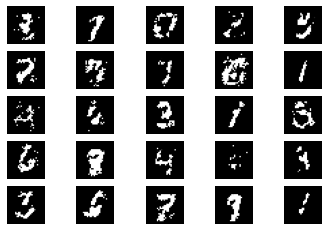

4401 [D loss: 0.136126, acc: 96.88%] [G loss: 6.793822]
4402 [D loss: 0.145707, acc: 96.09%] [G loss: 4.744847]
4403 [D loss: 0.088795, acc: 98.44%] [G loss: 5.419842]
4404 [D loss: 0.072421, acc: 99.61%] [G loss: 5.004812]
4405 [D loss: 0.098501, acc: 99.22%] [G loss: 5.665958]
4406 [D loss: 0.085663, acc: 98.83%] [G loss: 4.935491]
4407 [D loss: 0.089648, acc: 99.22%] [G loss: 5.697633]
4408 [D loss: 0.078379, acc: 99.61%] [G loss: 5.114919]
4409 [D loss: 0.089175, acc: 99.22%] [G loss: 5.713630]
4410 [D loss: 0.096128, acc: 98.44%] [G loss: 5.308541]
4411 [D loss: 0.093410, acc: 98.44%] [G loss: 5.487553]
4412 [D loss: 0.080749, acc: 100.00%] [G loss: 5.766979]
4413 [D loss: 0.133068, acc: 98.05%] [G loss: 5.961191]
4414 [D loss: 0.177019, acc: 95.70%] [G loss: 7.719384]
4415 [D loss: 0.812856, acc: 56.25%] [G loss: 18.286114]
4416 [D loss: 5.996301, acc: 7.03%] [G loss: 0.004937]
4417 [D loss: 3.003073, acc: 50.00%] [G loss: 0.064584]
4418 [D loss: 1.477575, acc: 50.78%] [G loss: 1

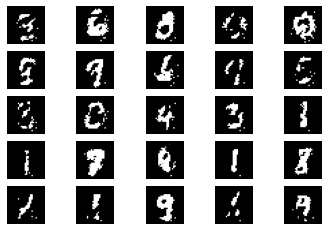

4601 [D loss: 0.064654, acc: 100.00%] [G loss: 5.120128]
4602 [D loss: 0.063169, acc: 99.61%] [G loss: 5.139127]
4603 [D loss: 0.041846, acc: 100.00%] [G loss: 5.137820]
4604 [D loss: 0.111542, acc: 98.05%] [G loss: 5.943285]
4605 [D loss: 0.079619, acc: 98.44%] [G loss: 4.863435]
4606 [D loss: 0.060543, acc: 100.00%] [G loss: 5.768877]
4607 [D loss: 0.065216, acc: 99.61%] [G loss: 4.888986]
4608 [D loss: 0.057880, acc: 99.61%] [G loss: 5.729008]
4609 [D loss: 0.066640, acc: 98.44%] [G loss: 5.030662]
4610 [D loss: 0.054094, acc: 99.22%] [G loss: 5.439899]
4611 [D loss: 0.039089, acc: 100.00%] [G loss: 5.382142]
4612 [D loss: 0.042977, acc: 100.00%] [G loss: 5.375132]
4613 [D loss: 0.077241, acc: 99.22%] [G loss: 5.750281]
4614 [D loss: 0.087916, acc: 98.83%] [G loss: 5.425669]
4615 [D loss: 0.079662, acc: 98.83%] [G loss: 5.940214]
4616 [D loss: 0.076473, acc: 98.83%] [G loss: 4.952536]
4617 [D loss: 0.060815, acc: 99.22%] [G loss: 6.581200]
4618 [D loss: 0.093047, acc: 99.22%] [G los

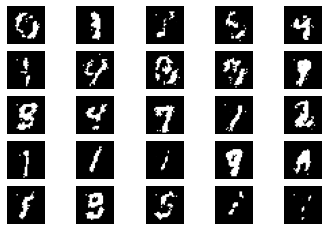

4801 [D loss: 0.063876, acc: 99.22%] [G loss: 5.894940]
4802 [D loss: 0.053841, acc: 99.22%] [G loss: 5.625444]
4803 [D loss: 0.052224, acc: 100.00%] [G loss: 5.448031]
4804 [D loss: 0.056171, acc: 99.22%] [G loss: 5.903745]
4805 [D loss: 0.035432, acc: 100.00%] [G loss: 5.624518]
4806 [D loss: 0.032812, acc: 100.00%] [G loss: 5.815880]
4807 [D loss: 0.041776, acc: 100.00%] [G loss: 5.735407]
4808 [D loss: 0.053387, acc: 99.61%] [G loss: 5.458689]
4809 [D loss: 0.048580, acc: 99.22%] [G loss: 5.888101]
4810 [D loss: 0.061793, acc: 99.22%] [G loss: 5.314508]
4811 [D loss: 0.050073, acc: 100.00%] [G loss: 6.547036]
4812 [D loss: 0.069155, acc: 99.22%] [G loss: 5.874999]
4813 [D loss: 0.067573, acc: 99.22%] [G loss: 5.623516]
4814 [D loss: 0.036000, acc: 100.00%] [G loss: 5.616661]
4815 [D loss: 0.032157, acc: 100.00%] [G loss: 6.173197]
4816 [D loss: 0.050300, acc: 100.00%] [G loss: 5.450822]
4817 [D loss: 0.064302, acc: 99.22%] [G loss: 6.578441]
4818 [D loss: 0.048022, acc: 99.61%] [G 

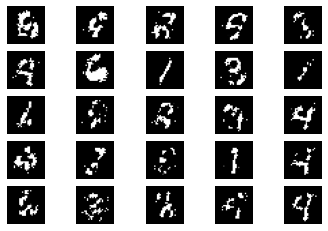

5001 [D loss: 0.246733, acc: 96.09%] [G loss: 3.316442]
5002 [D loss: 0.253921, acc: 95.70%] [G loss: 3.678533]
5003 [D loss: 0.257775, acc: 93.75%] [G loss: 3.187777]
5004 [D loss: 0.243052, acc: 95.70%] [G loss: 3.678805]
5005 [D loss: 0.234274, acc: 94.92%] [G loss: 3.551386]
5006 [D loss: 0.272567, acc: 96.48%] [G loss: 3.654022]
5007 [D loss: 0.200037, acc: 97.27%] [G loss: 3.957813]
5008 [D loss: 0.224776, acc: 94.92%] [G loss: 3.518651]
5009 [D loss: 0.260896, acc: 95.31%] [G loss: 3.872331]
5010 [D loss: 0.206146, acc: 96.09%] [G loss: 3.828659]
5011 [D loss: 0.226499, acc: 93.75%] [G loss: 3.488591]
5012 [D loss: 0.305633, acc: 92.19%] [G loss: 4.158109]
5013 [D loss: 0.194015, acc: 94.92%] [G loss: 3.683885]
5014 [D loss: 0.228901, acc: 96.48%] [G loss: 3.869962]
5015 [D loss: 0.194327, acc: 95.70%] [G loss: 3.921348]
5016 [D loss: 0.207945, acc: 95.70%] [G loss: 3.551028]
5017 [D loss: 0.226377, acc: 95.70%] [G loss: 4.276307]
5018 [D loss: 0.275165, acc: 91.02%] [G loss: 3.

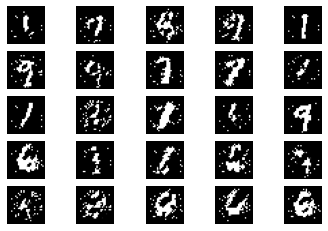

5201 [D loss: 0.054176, acc: 99.22%] [G loss: 6.654978]
5202 [D loss: 0.035372, acc: 99.22%] [G loss: 7.144374]
5203 [D loss: 0.034409, acc: 100.00%] [G loss: 5.844159]
5204 [D loss: 0.036066, acc: 100.00%] [G loss: 6.811150]
5205 [D loss: 0.041927, acc: 100.00%] [G loss: 6.875129]
5206 [D loss: 0.025324, acc: 100.00%] [G loss: 6.397058]
5207 [D loss: 0.047049, acc: 99.61%] [G loss: 7.345150]
5208 [D loss: 0.066442, acc: 98.83%] [G loss: 6.529521]
5209 [D loss: 0.040892, acc: 99.22%] [G loss: 7.345971]
5210 [D loss: 0.069083, acc: 99.22%] [G loss: 6.633487]
5211 [D loss: 0.044282, acc: 99.22%] [G loss: 6.845858]
5212 [D loss: 0.170701, acc: 92.58%] [G loss: 11.511578]
5213 [D loss: 5.045035, acc: 26.56%] [G loss: 0.235335]
5214 [D loss: 0.528936, acc: 71.48%] [G loss: 14.073262]
5215 [D loss: 1.378490, acc: 33.59%] [G loss: 2.004721]
5216 [D loss: 0.175548, acc: 92.97%] [G loss: 6.124317]
5217 [D loss: 0.054968, acc: 100.00%] [G loss: 7.526363]
5218 [D loss: 0.138086, acc: 95.31%] [G l

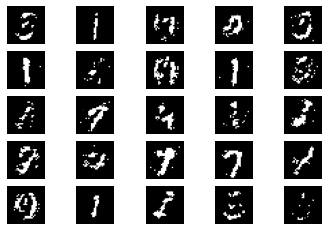

5401 [D loss: 0.135093, acc: 96.48%] [G loss: 5.838549]
5402 [D loss: 0.110305, acc: 98.44%] [G loss: 5.655490]
5403 [D loss: 0.181926, acc: 95.31%] [G loss: 7.627085]
5404 [D loss: 0.625375, acc: 64.06%] [G loss: 13.077753]
5405 [D loss: 4.194923, acc: 10.55%] [G loss: 0.027447]
5406 [D loss: 1.863334, acc: 50.00%] [G loss: 1.974977]
5407 [D loss: 0.105552, acc: 98.44%] [G loss: 6.732452]
5408 [D loss: 0.832606, acc: 55.86%] [G loss: 1.873958]
5409 [D loss: 0.289809, acc: 84.77%] [G loss: 3.915225]
5410 [D loss: 0.192389, acc: 96.09%] [G loss: 4.390683]
5411 [D loss: 0.227885, acc: 95.31%] [G loss: 3.182640]
5412 [D loss: 0.164793, acc: 97.27%] [G loss: 3.777589]
5413 [D loss: 0.183567, acc: 96.48%] [G loss: 3.959654]
5414 [D loss: 0.157543, acc: 96.88%] [G loss: 3.901740]
5415 [D loss: 0.159020, acc: 98.44%] [G loss: 3.890106]
5416 [D loss: 0.181409, acc: 98.05%] [G loss: 4.022300]
5417 [D loss: 0.159769, acc: 96.48%] [G loss: 4.073546]
5418 [D loss: 0.148393, acc: 99.61%] [G loss: 4

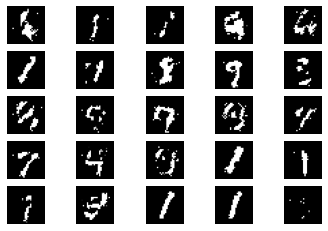

5601 [D loss: 0.057065, acc: 98.83%] [G loss: 6.489412]
5602 [D loss: 0.070558, acc: 98.83%] [G loss: 6.651394]
5603 [D loss: 0.037171, acc: 99.61%] [G loss: 5.838518]
5604 [D loss: 0.033786, acc: 100.00%] [G loss: 6.590904]
5605 [D loss: 0.023151, acc: 100.00%] [G loss: 5.974405]
5606 [D loss: 0.047266, acc: 100.00%] [G loss: 6.338264]
5607 [D loss: 0.055594, acc: 98.83%] [G loss: 5.971765]
5608 [D loss: 0.024903, acc: 100.00%] [G loss: 6.265396]
5609 [D loss: 0.027930, acc: 100.00%] [G loss: 6.041319]
5610 [D loss: 0.036014, acc: 100.00%] [G loss: 5.960422]
5611 [D loss: 0.020325, acc: 100.00%] [G loss: 6.414131]
5612 [D loss: 0.053495, acc: 99.22%] [G loss: 6.260255]
5613 [D loss: 0.026333, acc: 99.61%] [G loss: 6.377450]
5614 [D loss: 0.025959, acc: 100.00%] [G loss: 6.063634]
5615 [D loss: 0.025980, acc: 100.00%] [G loss: 5.938457]
5616 [D loss: 0.034980, acc: 99.61%] [G loss: 5.987031]
5617 [D loss: 0.020994, acc: 100.00%] [G loss: 6.703458]
5618 [D loss: 0.021917, acc: 100.00%] 

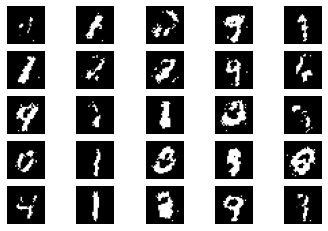

5801 [D loss: 0.027313, acc: 100.00%] [G loss: 6.581196]
5802 [D loss: 0.027963, acc: 99.61%] [G loss: 6.362689]
5803 [D loss: 0.013130, acc: 100.00%] [G loss: 6.200427]
5804 [D loss: 0.051129, acc: 99.22%] [G loss: 7.490258]
5805 [D loss: 0.032382, acc: 99.22%] [G loss: 5.754088]
5806 [D loss: 0.026029, acc: 99.61%] [G loss: 6.925829]
5807 [D loss: 0.028213, acc: 99.61%] [G loss: 6.153007]
5808 [D loss: 0.025685, acc: 99.61%] [G loss: 6.417416]
5809 [D loss: 0.018581, acc: 100.00%] [G loss: 6.249005]
5810 [D loss: 0.052716, acc: 99.61%] [G loss: 8.035557]
5811 [D loss: 0.051201, acc: 98.83%] [G loss: 5.691980]
5812 [D loss: 0.020610, acc: 100.00%] [G loss: 7.129638]
5813 [D loss: 0.033333, acc: 99.22%] [G loss: 6.305667]
5814 [D loss: 0.022262, acc: 100.00%] [G loss: 6.365414]
5815 [D loss: 0.021717, acc: 100.00%] [G loss: 6.325154]
5816 [D loss: 0.019175, acc: 100.00%] [G loss: 6.125381]
5817 [D loss: 0.024427, acc: 100.00%] [G loss: 6.570069]
5818 [D loss: 0.037847, acc: 99.22%] [G 

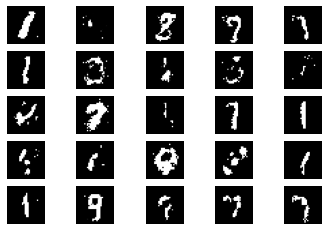

6001 [D loss: 0.571651, acc: 69.53%] [G loss: 1.543391]
6002 [D loss: 0.564749, acc: 67.58%] [G loss: 1.634826]
6003 [D loss: 0.447605, acc: 80.47%] [G loss: 1.784162]
6004 [D loss: 0.513681, acc: 74.61%] [G loss: 1.696930]
6005 [D loss: 0.577845, acc: 71.48%] [G loss: 1.572809]
6006 [D loss: 0.491287, acc: 77.34%] [G loss: 1.677655]
6007 [D loss: 0.481430, acc: 76.17%] [G loss: 1.793002]
6008 [D loss: 0.606077, acc: 69.14%] [G loss: 1.502426]
6009 [D loss: 0.557983, acc: 71.88%] [G loss: 1.700256]
6010 [D loss: 0.550153, acc: 69.92%] [G loss: 1.686130]
6011 [D loss: 0.506573, acc: 75.39%] [G loss: 1.633693]
6012 [D loss: 0.464606, acc: 79.30%] [G loss: 1.809157]
6013 [D loss: 0.525034, acc: 74.61%] [G loss: 1.702152]
6014 [D loss: 0.538923, acc: 70.31%] [G loss: 1.645704]
6015 [D loss: 0.545645, acc: 73.05%] [G loss: 1.667856]
6016 [D loss: 0.523555, acc: 74.22%] [G loss: 1.703186]
6017 [D loss: 0.439410, acc: 82.42%] [G loss: 1.878766]
6018 [D loss: 0.563850, acc: 70.31%] [G loss: 1.

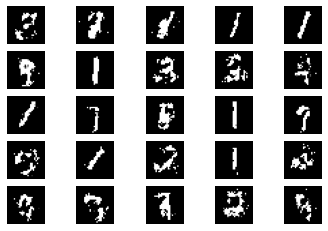

6201 [D loss: 0.176287, acc: 96.88%] [G loss: 4.649580]
6202 [D loss: 0.153493, acc: 97.27%] [G loss: 4.254487]
6203 [D loss: 0.182292, acc: 95.70%] [G loss: 5.043736]
6204 [D loss: 0.201228, acc: 94.14%] [G loss: 4.456288]
6205 [D loss: 0.120637, acc: 98.83%] [G loss: 4.653147]
6206 [D loss: 0.173927, acc: 96.09%] [G loss: 5.124859]
6207 [D loss: 0.210453, acc: 93.75%] [G loss: 5.309609]
6208 [D loss: 0.183798, acc: 94.92%] [G loss: 4.605129]
6209 [D loss: 0.119523, acc: 96.88%] [G loss: 4.523441]
6210 [D loss: 0.166422, acc: 96.48%] [G loss: 5.307923]
6211 [D loss: 0.132667, acc: 96.88%] [G loss: 4.336717]
6212 [D loss: 0.183832, acc: 96.48%] [G loss: 5.599478]
6213 [D loss: 0.206792, acc: 95.31%] [G loss: 4.565286]
6214 [D loss: 0.116269, acc: 98.44%] [G loss: 4.927988]
6215 [D loss: 0.187483, acc: 95.70%] [G loss: 5.868699]
6216 [D loss: 0.173942, acc: 95.70%] [G loss: 4.195791]
6217 [D loss: 0.070777, acc: 100.00%] [G loss: 5.075452]
6218 [D loss: 0.147269, acc: 98.44%] [G loss: 5

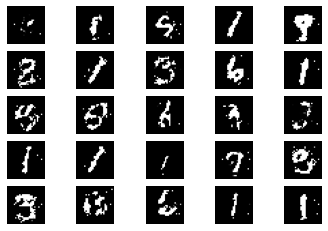

6401 [D loss: 0.329918, acc: 91.41%] [G loss: 2.395452]
6402 [D loss: 0.329997, acc: 91.41%] [G loss: 2.526542]
6403 [D loss: 0.347013, acc: 89.45%] [G loss: 2.337928]
6404 [D loss: 0.297190, acc: 90.62%] [G loss: 2.534000]
6405 [D loss: 0.295429, acc: 94.14%] [G loss: 2.443399]
6406 [D loss: 0.321795, acc: 91.41%] [G loss: 2.396662]
6407 [D loss: 0.272814, acc: 95.31%] [G loss: 2.709091]
6408 [D loss: 0.343575, acc: 90.23%] [G loss: 2.434743]
6409 [D loss: 0.259970, acc: 96.09%] [G loss: 2.654748]
6410 [D loss: 0.300390, acc: 91.80%] [G loss: 2.642602]
6411 [D loss: 0.295153, acc: 92.58%] [G loss: 2.645582]
6412 [D loss: 0.333292, acc: 88.67%] [G loss: 2.563347]
6413 [D loss: 0.276690, acc: 93.36%] [G loss: 2.876949]
6414 [D loss: 0.354794, acc: 89.84%] [G loss: 2.628469]
6415 [D loss: 0.278412, acc: 94.53%] [G loss: 2.808745]
6416 [D loss: 0.319992, acc: 90.23%] [G loss: 2.818728]
6417 [D loss: 0.290199, acc: 92.97%] [G loss: 2.759288]
6418 [D loss: 0.253211, acc: 96.09%] [G loss: 2.

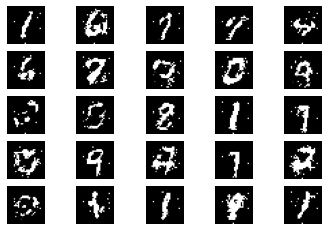

6601 [D loss: 0.288147, acc: 94.53%] [G loss: 2.907393]
6602 [D loss: 0.285672, acc: 91.80%] [G loss: 2.932143]
6603 [D loss: 0.302977, acc: 93.36%] [G loss: 2.701811]
6604 [D loss: 0.242725, acc: 96.09%] [G loss: 3.231099]
6605 [D loss: 0.288618, acc: 93.75%] [G loss: 3.015775]
6606 [D loss: 0.261180, acc: 94.92%] [G loss: 2.970466]
6607 [D loss: 0.259446, acc: 96.48%] [G loss: 3.057126]
6608 [D loss: 0.240707, acc: 96.88%] [G loss: 3.266703]
6609 [D loss: 0.266451, acc: 97.27%] [G loss: 3.148383]
6610 [D loss: 0.228288, acc: 96.88%] [G loss: 3.176109]
6611 [D loss: 0.248866, acc: 95.70%] [G loss: 3.058938]
6612 [D loss: 0.207024, acc: 96.88%] [G loss: 3.301166]
6613 [D loss: 0.201432, acc: 98.05%] [G loss: 3.302675]
6614 [D loss: 0.197401, acc: 99.22%] [G loss: 3.366523]
6615 [D loss: 0.188320, acc: 97.66%] [G loss: 3.485745]
6616 [D loss: 0.179490, acc: 99.22%] [G loss: 3.596909]
6617 [D loss: 0.163548, acc: 98.83%] [G loss: 3.559123]
6618 [D loss: 0.169403, acc: 98.83%] [G loss: 3.

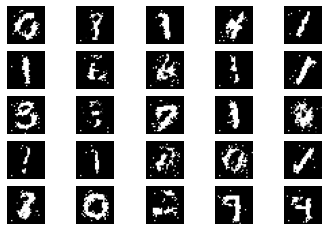

6801 [D loss: 0.322188, acc: 89.84%] [G loss: 3.012130]
6802 [D loss: 0.328970, acc: 86.33%] [G loss: 3.276502]
6803 [D loss: 0.307559, acc: 91.02%] [G loss: 3.213116]
6804 [D loss: 0.258885, acc: 93.36%] [G loss: 3.207728]
6805 [D loss: 0.257568, acc: 94.14%] [G loss: 3.228298]
6806 [D loss: 0.255983, acc: 92.97%] [G loss: 3.311192]
6807 [D loss: 0.334129, acc: 86.72%] [G loss: 3.379410]
6808 [D loss: 0.326322, acc: 87.89%] [G loss: 3.386066]
6809 [D loss: 0.318619, acc: 90.23%] [G loss: 3.317599]
6810 [D loss: 0.339768, acc: 87.50%] [G loss: 3.314264]
6811 [D loss: 0.309613, acc: 92.19%] [G loss: 3.627922]
6812 [D loss: 0.347688, acc: 88.67%] [G loss: 3.184138]
6813 [D loss: 0.285917, acc: 92.19%] [G loss: 3.545846]
6814 [D loss: 0.282095, acc: 91.41%] [G loss: 3.662908]
6815 [D loss: 0.344495, acc: 86.72%] [G loss: 3.403469]
6816 [D loss: 0.283905, acc: 89.84%] [G loss: 3.657531]
6817 [D loss: 0.391343, acc: 82.81%] [G loss: 3.155634]
6818 [D loss: 0.217911, acc: 94.14%] [G loss: 3.

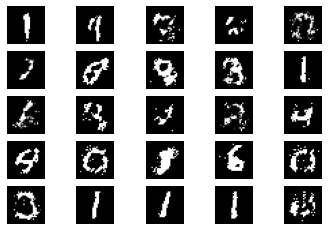

7001 [D loss: 0.274208, acc: 90.62%] [G loss: 5.637635]
7002 [D loss: 0.112154, acc: 96.88%] [G loss: 5.884607]
7003 [D loss: 0.092533, acc: 98.44%] [G loss: 6.016578]
7004 [D loss: 0.199937, acc: 91.80%] [G loss: 7.054968]
7005 [D loss: 0.199951, acc: 94.53%] [G loss: 5.413250]
7006 [D loss: 0.137393, acc: 95.31%] [G loss: 6.076880]
7007 [D loss: 0.247211, acc: 91.41%] [G loss: 6.603367]
7008 [D loss: 0.166855, acc: 95.31%] [G loss: 4.729837]
7009 [D loss: 0.105731, acc: 97.27%] [G loss: 6.444460]
7010 [D loss: 0.172534, acc: 95.31%] [G loss: 5.057265]
7011 [D loss: 0.145370, acc: 94.53%] [G loss: 7.481689]
7012 [D loss: 0.569736, acc: 75.39%] [G loss: 9.267040]
7013 [D loss: 1.117936, acc: 44.92%] [G loss: 10.504038]
7014 [D loss: 1.156323, acc: 48.05%] [G loss: 6.273443]
7015 [D loss: 0.142610, acc: 95.31%] [G loss: 7.500140]
7016 [D loss: 0.945849, acc: 55.47%] [G loss: 4.941344]
7017 [D loss: 0.096074, acc: 98.05%] [G loss: 6.569713]
7018 [D loss: 0.530010, acc: 73.05%] [G loss: 5

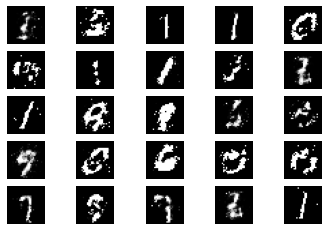

7201 [D loss: 0.592524, acc: 71.48%] [G loss: 3.348563]
7202 [D loss: 0.336003, acc: 86.72%] [G loss: 4.843254]
7203 [D loss: 0.516964, acc: 71.88%] [G loss: 3.937801]
7204 [D loss: 0.370575, acc: 81.25%] [G loss: 4.162427]
7205 [D loss: 0.515535, acc: 73.05%] [G loss: 3.642572]
7206 [D loss: 0.409519, acc: 79.69%] [G loss: 4.055726]
7207 [D loss: 0.531038, acc: 74.61%] [G loss: 4.305462]
7208 [D loss: 0.460656, acc: 78.12%] [G loss: 4.084915]
7209 [D loss: 0.501337, acc: 76.56%] [G loss: 4.198802]
7210 [D loss: 0.523663, acc: 76.95%] [G loss: 3.990834]
7211 [D loss: 0.477765, acc: 79.30%] [G loss: 3.996534]
7212 [D loss: 0.571276, acc: 70.31%] [G loss: 3.623852]
7213 [D loss: 0.462495, acc: 76.95%] [G loss: 4.321566]
7214 [D loss: 0.434883, acc: 80.08%] [G loss: 3.462404]
7215 [D loss: 0.474822, acc: 75.78%] [G loss: 4.626912]
7216 [D loss: 0.575095, acc: 71.48%] [G loss: 3.419669]
7217 [D loss: 0.420162, acc: 78.52%] [G loss: 4.391343]
7218 [D loss: 0.673832, acc: 64.84%] [G loss: 3.

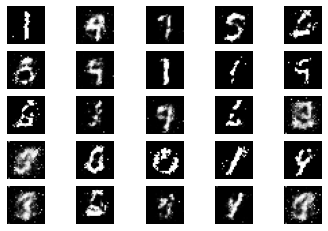

7401 [D loss: 0.566400, acc: 66.80%] [G loss: 1.803900]
7402 [D loss: 0.560251, acc: 65.62%] [G loss: 2.179152]
7403 [D loss: 0.568031, acc: 64.06%] [G loss: 2.045876]
7404 [D loss: 0.599320, acc: 62.89%] [G loss: 1.528418]
7405 [D loss: 0.578808, acc: 61.33%] [G loss: 1.982579]
7406 [D loss: 0.565288, acc: 61.33%] [G loss: 1.641368]
7407 [D loss: 0.575849, acc: 62.89%] [G loss: 1.781205]
7408 [D loss: 0.649968, acc: 59.38%] [G loss: 1.695503]
7409 [D loss: 0.585004, acc: 63.28%] [G loss: 2.090979]
7410 [D loss: 0.570083, acc: 65.23%] [G loss: 1.986253]
7411 [D loss: 0.558969, acc: 65.23%] [G loss: 2.052742]
7412 [D loss: 0.627567, acc: 60.94%] [G loss: 2.391661]
7413 [D loss: 0.589360, acc: 66.41%] [G loss: 1.881162]
7414 [D loss: 0.566673, acc: 64.06%] [G loss: 1.687286]
7415 [D loss: 0.562831, acc: 64.06%] [G loss: 1.928998]
7416 [D loss: 0.593442, acc: 62.11%] [G loss: 1.664125]
7417 [D loss: 0.611416, acc: 57.42%] [G loss: 1.696366]
7418 [D loss: 0.545927, acc: 66.41%] [G loss: 2.

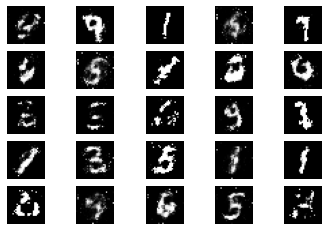

7601 [D loss: 0.566791, acc: 64.45%] [G loss: 1.668628]
7602 [D loss: 0.554116, acc: 67.97%] [G loss: 1.679336]
7603 [D loss: 0.533457, acc: 69.53%] [G loss: 1.385454]
7604 [D loss: 0.567384, acc: 66.80%] [G loss: 1.581998]
7605 [D loss: 0.546893, acc: 68.75%] [G loss: 1.902262]
7606 [D loss: 0.594943, acc: 65.23%] [G loss: 1.486755]
7607 [D loss: 0.578832, acc: 63.28%] [G loss: 1.532438]
7608 [D loss: 0.616684, acc: 62.89%] [G loss: 1.559120]
7609 [D loss: 0.583397, acc: 67.97%] [G loss: 1.626680]
7610 [D loss: 0.604460, acc: 66.02%] [G loss: 1.962235]
7611 [D loss: 0.551013, acc: 66.41%] [G loss: 1.307162]
7612 [D loss: 0.594486, acc: 65.62%] [G loss: 1.710456]
7613 [D loss: 0.556716, acc: 64.84%] [G loss: 2.087670]
7614 [D loss: 0.541851, acc: 67.97%] [G loss: 2.220458]
7615 [D loss: 0.554773, acc: 69.92%] [G loss: 1.954377]
7616 [D loss: 0.506838, acc: 73.44%] [G loss: 1.544837]
7617 [D loss: 0.541909, acc: 72.66%] [G loss: 1.607138]
7618 [D loss: 0.535571, acc: 71.48%] [G loss: 1.

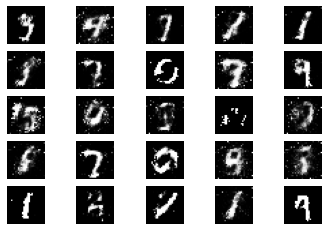

7801 [D loss: 0.562056, acc: 68.36%] [G loss: 1.453315]
7802 [D loss: 0.641246, acc: 57.81%] [G loss: 1.116012]
7803 [D loss: 0.595385, acc: 64.45%] [G loss: 1.773086]
7804 [D loss: 0.581046, acc: 67.19%] [G loss: 1.913527]
7805 [D loss: 0.630763, acc: 62.11%] [G loss: 1.347631]
7806 [D loss: 0.569505, acc: 67.19%] [G loss: 1.371261]
7807 [D loss: 0.573381, acc: 65.23%] [G loss: 1.430353]
7808 [D loss: 0.538167, acc: 70.31%] [G loss: 1.387619]
7809 [D loss: 0.571469, acc: 69.53%] [G loss: 1.247163]
7810 [D loss: 0.565108, acc: 71.48%] [G loss: 1.296519]
7811 [D loss: 0.531073, acc: 73.44%] [G loss: 1.552606]
7812 [D loss: 0.516555, acc: 77.34%] [G loss: 1.501016]
7813 [D loss: 0.560321, acc: 70.31%] [G loss: 1.432004]
7814 [D loss: 0.523720, acc: 75.39%] [G loss: 1.340114]
7815 [D loss: 0.520972, acc: 73.05%] [G loss: 1.309479]
7816 [D loss: 0.567591, acc: 70.31%] [G loss: 1.314673]
7817 [D loss: 0.586991, acc: 67.58%] [G loss: 1.309516]
7818 [D loss: 0.572395, acc: 68.36%] [G loss: 1.

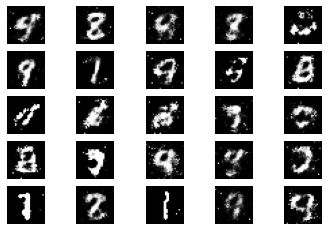

8001 [D loss: 0.559820, acc: 69.14%] [G loss: 0.892524]
8002 [D loss: 0.590160, acc: 68.36%] [G loss: 1.420499]
8003 [D loss: 0.584163, acc: 68.75%] [G loss: 1.366429]
8004 [D loss: 0.561939, acc: 69.53%] [G loss: 1.487306]
8005 [D loss: 0.584620, acc: 70.70%] [G loss: 1.363537]
8006 [D loss: 0.550229, acc: 75.39%] [G loss: 1.245209]
8007 [D loss: 0.563945, acc: 69.14%] [G loss: 1.482040]
8008 [D loss: 0.562144, acc: 69.14%] [G loss: 1.681724]
8009 [D loss: 0.627753, acc: 64.45%] [G loss: 1.038232]
8010 [D loss: 0.577394, acc: 69.92%] [G loss: 1.249109]
8011 [D loss: 0.590030, acc: 68.36%] [G loss: 1.474968]
8012 [D loss: 0.572923, acc: 66.80%] [G loss: 1.351958]
8013 [D loss: 0.565854, acc: 68.75%] [G loss: 1.315723]
8014 [D loss: 0.599238, acc: 71.09%] [G loss: 1.710350]
8015 [D loss: 0.574308, acc: 65.62%] [G loss: 1.436950]
8016 [D loss: 0.556052, acc: 71.09%] [G loss: 1.301417]
8017 [D loss: 0.583304, acc: 65.23%] [G loss: 1.358721]
8018 [D loss: 0.581528, acc: 66.41%] [G loss: 1.

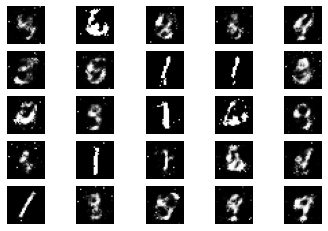

8201 [D loss: 0.552190, acc: 73.05%] [G loss: 1.148508]
8202 [D loss: 0.596360, acc: 69.14%] [G loss: 1.743880]
8203 [D loss: 0.525033, acc: 76.56%] [G loss: 1.398638]
8204 [D loss: 0.528642, acc: 74.22%] [G loss: 1.490545]
8205 [D loss: 0.549885, acc: 70.31%] [G loss: 1.320027]
8206 [D loss: 0.529548, acc: 73.83%] [G loss: 1.383116]
8207 [D loss: 0.567353, acc: 70.31%] [G loss: 1.288828]
8208 [D loss: 0.519947, acc: 72.27%] [G loss: 1.581832]
8209 [D loss: 0.565832, acc: 71.09%] [G loss: 1.278135]
8210 [D loss: 0.551113, acc: 69.92%] [G loss: 1.435522]
8211 [D loss: 0.547066, acc: 71.88%] [G loss: 1.315015]
8212 [D loss: 0.547359, acc: 72.27%] [G loss: 1.664145]
8213 [D loss: 0.528715, acc: 73.05%] [G loss: 1.471000]
8214 [D loss: 0.591170, acc: 66.41%] [G loss: 1.177920]
8215 [D loss: 0.578818, acc: 67.19%] [G loss: 1.301783]
8216 [D loss: 0.622197, acc: 62.50%] [G loss: 1.944231]
8217 [D loss: 0.579961, acc: 69.53%] [G loss: 1.292731]
8218 [D loss: 0.584102, acc: 69.53%] [G loss: 1.

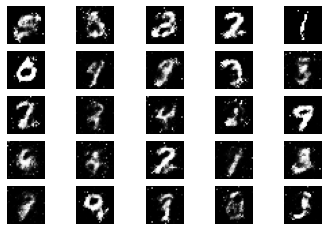

8401 [D loss: 0.596108, acc: 67.19%] [G loss: 1.195169]
8402 [D loss: 0.528554, acc: 79.30%] [G loss: 1.318297]
8403 [D loss: 0.631208, acc: 66.02%] [G loss: 1.693379]
8404 [D loss: 0.570532, acc: 71.88%] [G loss: 1.461031]
8405 [D loss: 0.574072, acc: 68.75%] [G loss: 1.185697]
8406 [D loss: 0.619987, acc: 64.06%] [G loss: 1.444873]
8407 [D loss: 0.623632, acc: 63.28%] [G loss: 1.213819]
8408 [D loss: 0.568334, acc: 68.75%] [G loss: 1.296103]
8409 [D loss: 0.591334, acc: 65.23%] [G loss: 1.473998]
8410 [D loss: 0.583331, acc: 64.45%] [G loss: 1.300811]
8411 [D loss: 0.651186, acc: 56.25%] [G loss: 1.123233]
8412 [D loss: 0.606571, acc: 62.50%] [G loss: 1.163738]
8413 [D loss: 0.586325, acc: 67.97%] [G loss: 1.377792]
8414 [D loss: 0.565553, acc: 71.09%] [G loss: 1.566681]
8415 [D loss: 0.580405, acc: 65.23%] [G loss: 1.134822]
8416 [D loss: 0.582914, acc: 67.19%] [G loss: 1.224520]
8417 [D loss: 0.596512, acc: 66.80%] [G loss: 1.359275]
8418 [D loss: 0.591045, acc: 64.84%] [G loss: 1.

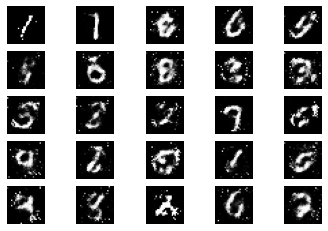

8601 [D loss: 0.577314, acc: 70.31%] [G loss: 1.073501]
8602 [D loss: 0.554672, acc: 73.44%] [G loss: 1.197903]
8603 [D loss: 0.577132, acc: 67.58%] [G loss: 1.216181]
8604 [D loss: 0.550745, acc: 77.73%] [G loss: 1.274849]
8605 [D loss: 0.541746, acc: 76.17%] [G loss: 1.351513]
8606 [D loss: 0.539338, acc: 74.22%] [G loss: 1.299633]
8607 [D loss: 0.554589, acc: 71.88%] [G loss: 1.276033]
8608 [D loss: 0.562927, acc: 68.36%] [G loss: 1.397890]
8609 [D loss: 0.575379, acc: 66.41%] [G loss: 1.098339]
8610 [D loss: 0.574658, acc: 67.58%] [G loss: 1.366295]
8611 [D loss: 0.587778, acc: 69.14%] [G loss: 1.247615]
8612 [D loss: 0.567369, acc: 69.92%] [G loss: 1.513881]
8613 [D loss: 0.629216, acc: 62.11%] [G loss: 1.173782]
8614 [D loss: 0.681384, acc: 55.47%] [G loss: 1.449216]
8615 [D loss: 0.627711, acc: 57.03%] [G loss: 1.319950]
8616 [D loss: 0.586695, acc: 68.36%] [G loss: 1.293770]
8617 [D loss: 0.605012, acc: 69.53%] [G loss: 1.328173]
8618 [D loss: 0.591687, acc: 67.19%] [G loss: 1.

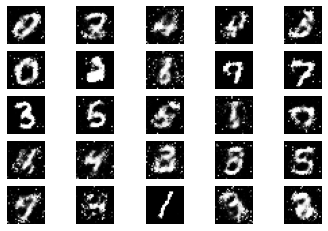

8801 [D loss: 0.583931, acc: 67.97%] [G loss: 1.183764]
8802 [D loss: 0.569907, acc: 69.14%] [G loss: 1.187078]
8803 [D loss: 0.571485, acc: 71.88%] [G loss: 1.157276]
8804 [D loss: 0.572443, acc: 70.31%] [G loss: 1.051859]
8805 [D loss: 0.551495, acc: 71.88%] [G loss: 0.967064]
8806 [D loss: 0.676529, acc: 57.03%] [G loss: 1.101953]
8807 [D loss: 0.606458, acc: 61.72%] [G loss: 1.539917]
8808 [D loss: 0.584626, acc: 69.92%] [G loss: 1.423756]
8809 [D loss: 0.557433, acc: 70.31%] [G loss: 1.214442]
8810 [D loss: 0.618203, acc: 61.72%] [G loss: 1.254399]
8811 [D loss: 0.593037, acc: 67.19%] [G loss: 1.247552]
8812 [D loss: 0.610623, acc: 65.62%] [G loss: 1.030364]
8813 [D loss: 0.609343, acc: 64.06%] [G loss: 1.025527]
8814 [D loss: 0.567474, acc: 69.14%] [G loss: 1.779760]
8815 [D loss: 0.654931, acc: 62.11%] [G loss: 0.841487]
8816 [D loss: 0.678891, acc: 59.77%] [G loss: 0.883229]
8817 [D loss: 0.641873, acc: 59.38%] [G loss: 1.109467]
8818 [D loss: 0.559849, acc: 70.70%] [G loss: 1.

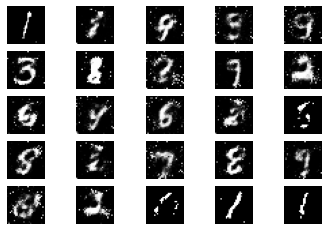

9001 [D loss: 0.609854, acc: 66.02%] [G loss: 1.749712]
9002 [D loss: 0.611322, acc: 67.19%] [G loss: 0.854466]
9003 [D loss: 0.626764, acc: 60.55%] [G loss: 1.008534]
9004 [D loss: 0.598226, acc: 63.28%] [G loss: 1.494176]
9005 [D loss: 0.584092, acc: 71.48%] [G loss: 1.065218]
9006 [D loss: 0.621905, acc: 67.19%] [G loss: 1.054255]
9007 [D loss: 0.584862, acc: 67.97%] [G loss: 1.283006]
9008 [D loss: 0.584650, acc: 70.70%] [G loss: 1.318482]
9009 [D loss: 0.526681, acc: 73.44%] [G loss: 1.600097]
9010 [D loss: 0.591723, acc: 67.97%] [G loss: 1.446522]
9011 [D loss: 0.569143, acc: 69.53%] [G loss: 1.319739]
9012 [D loss: 0.536812, acc: 74.22%] [G loss: 0.994120]
9013 [D loss: 0.560686, acc: 71.48%] [G loss: 0.717134]
9014 [D loss: 0.640102, acc: 60.94%] [G loss: 0.764819]
9015 [D loss: 0.633519, acc: 60.16%] [G loss: 1.357707]
9016 [D loss: 0.607870, acc: 64.84%] [G loss: 1.215425]
9017 [D loss: 0.615142, acc: 67.58%] [G loss: 2.333185]
9018 [D loss: 0.615265, acc: 64.45%] [G loss: 1.

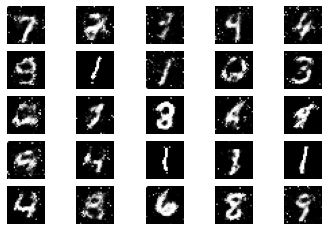

9201 [D loss: 0.618052, acc: 63.67%] [G loss: 1.659019]
9202 [D loss: 0.632108, acc: 63.67%] [G loss: 1.028573]
9203 [D loss: 0.641153, acc: 62.50%] [G loss: 1.170526]
9204 [D loss: 0.593085, acc: 66.41%] [G loss: 1.436892]
9205 [D loss: 0.633331, acc: 62.89%] [G loss: 1.024752]
9206 [D loss: 0.610227, acc: 64.06%] [G loss: 1.084971]
9207 [D loss: 0.590787, acc: 67.19%] [G loss: 1.732742]
9208 [D loss: 0.601890, acc: 66.02%] [G loss: 1.111858]
9209 [D loss: 0.587772, acc: 66.02%] [G loss: 1.246998]
9210 [D loss: 0.599638, acc: 66.41%] [G loss: 1.000639]
9211 [D loss: 0.579404, acc: 66.80%] [G loss: 1.253497]
9212 [D loss: 0.622921, acc: 62.50%] [G loss: 1.031476]
9213 [D loss: 0.572570, acc: 70.31%] [G loss: 1.110789]
9214 [D loss: 0.557439, acc: 75.00%] [G loss: 1.224156]
9215 [D loss: 0.560425, acc: 72.66%] [G loss: 1.148842]
9216 [D loss: 0.601258, acc: 66.41%] [G loss: 1.252804]
9217 [D loss: 0.601308, acc: 67.19%] [G loss: 1.280115]
9218 [D loss: 0.621649, acc: 63.28%] [G loss: 0.

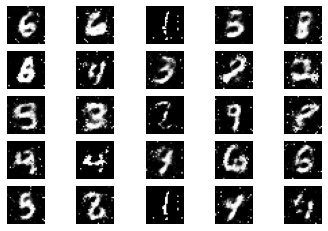

9401 [D loss: 0.613825, acc: 64.84%] [G loss: 1.024816]
9402 [D loss: 0.645428, acc: 60.94%] [G loss: 0.895109]
9403 [D loss: 0.686454, acc: 50.39%] [G loss: 1.035610]
9404 [D loss: 0.650105, acc: 58.20%] [G loss: 1.095525]
9405 [D loss: 0.669374, acc: 56.64%] [G loss: 1.335875]
9406 [D loss: 0.605562, acc: 66.80%] [G loss: 1.092590]
9407 [D loss: 0.610756, acc: 68.36%] [G loss: 1.014240]
9408 [D loss: 0.607544, acc: 67.58%] [G loss: 1.249280]
9409 [D loss: 0.616924, acc: 65.62%] [G loss: 1.055139]
9410 [D loss: 0.632257, acc: 62.11%] [G loss: 1.061608]
9411 [D loss: 0.592821, acc: 69.14%] [G loss: 0.991062]
9412 [D loss: 0.598747, acc: 67.58%] [G loss: 1.151303]
9413 [D loss: 0.602149, acc: 69.14%] [G loss: 1.136641]
9414 [D loss: 0.602077, acc: 64.45%] [G loss: 1.215357]
9415 [D loss: 0.622643, acc: 66.80%] [G loss: 0.996944]
9416 [D loss: 0.616852, acc: 67.19%] [G loss: 0.956089]
9417 [D loss: 0.599476, acc: 64.84%] [G loss: 1.208932]
9418 [D loss: 0.639576, acc: 61.72%] [G loss: 1.

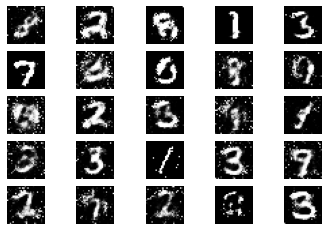

9601 [D loss: 0.633691, acc: 63.28%] [G loss: 1.286878]
9602 [D loss: 0.604550, acc: 67.58%] [G loss: 1.161248]
9603 [D loss: 0.574249, acc: 71.88%] [G loss: 1.137030]
9604 [D loss: 0.611267, acc: 66.41%] [G loss: 1.456302]
9605 [D loss: 0.576696, acc: 68.75%] [G loss: 1.531768]
9606 [D loss: 0.557788, acc: 71.88%] [G loss: 1.350996]
9607 [D loss: 0.613513, acc: 66.41%] [G loss: 1.089749]
9608 [D loss: 0.607238, acc: 67.97%] [G loss: 1.871903]
9609 [D loss: 0.625723, acc: 63.67%] [G loss: 1.091871]
9610 [D loss: 0.635884, acc: 64.06%] [G loss: 1.077125]
9611 [D loss: 0.608321, acc: 63.28%] [G loss: 2.220217]
9612 [D loss: 0.689285, acc: 59.77%] [G loss: 1.205415]
9613 [D loss: 0.719619, acc: 51.56%] [G loss: 1.047798]
9614 [D loss: 0.772493, acc: 47.66%] [G loss: 0.938693]
9615 [D loss: 0.758232, acc: 46.88%] [G loss: 0.955019]
9616 [D loss: 0.677467, acc: 56.25%] [G loss: 1.089919]
9617 [D loss: 0.569076, acc: 69.14%] [G loss: 1.490244]
9618 [D loss: 0.622603, acc: 64.45%] [G loss: 1.

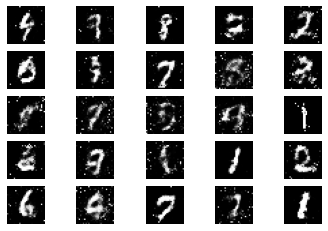

9801 [D loss: 0.655578, acc: 57.81%] [G loss: 1.061502]
9802 [D loss: 0.603308, acc: 67.97%] [G loss: 1.467554]
9803 [D loss: 0.622550, acc: 67.58%] [G loss: 0.917547]
9804 [D loss: 0.595419, acc: 68.75%] [G loss: 0.987457]
9805 [D loss: 0.655701, acc: 57.81%] [G loss: 0.886217]
9806 [D loss: 0.647194, acc: 60.55%] [G loss: 1.074353]
9807 [D loss: 0.605601, acc: 64.45%] [G loss: 1.288375]
9808 [D loss: 0.657477, acc: 59.38%] [G loss: 1.035473]
9809 [D loss: 0.591782, acc: 66.41%] [G loss: 1.081050]
9810 [D loss: 0.673424, acc: 58.20%] [G loss: 1.242848]
9811 [D loss: 0.575595, acc: 69.14%] [G loss: 1.353088]
9812 [D loss: 0.605455, acc: 67.19%] [G loss: 0.943643]
9813 [D loss: 0.589518, acc: 69.53%] [G loss: 1.698456]
9814 [D loss: 0.607016, acc: 63.67%] [G loss: 1.557025]
9815 [D loss: 0.619164, acc: 64.84%] [G loss: 0.772940]
9816 [D loss: 0.612793, acc: 65.62%] [G loss: 1.011075]
9817 [D loss: 0.620692, acc: 64.45%] [G loss: 2.017711]
9818 [D loss: 0.613030, acc: 64.84%] [G loss: 0.

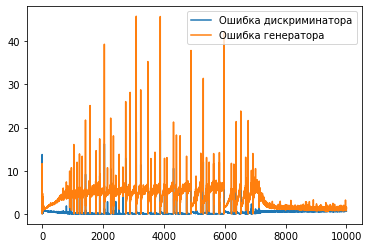

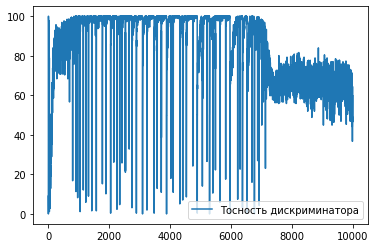

In [ ]:
generator = create_conv_generator(10)
discriminator = create_discriminator()
train(generator, discriminator , 10, 10000)

## latent_dim - **1000**

In [ ]:
generator = create_conv_generator(1000)
discriminator = create_discriminator()
train(generator, discriminator , 1000, 10000)

# Обучение с разными **batch_size**

Сделайте возможность запускать обучение с разными **batch_size** для генератора и дискриминатора, попробуйте запустить с batch_size **128** для дискриминатора и **256** для генератора, сравните результат с равными batch_size по **128**.

In [ ]:
# Функция обучения с разным batch_size

def train_different_batch(generator, discriminator, latent_dim=100, epochs=30000, batch_size_dis=128,  batch_size_gen=256):
  # Создаем массив единиц и нулей длинной batch_size
  valid = np.ones((batch_size_dis, 1))
  fake = np.zeros((batch_size_dis, 1))

  z = Input(shape=(latent_dim,))
  img = generator(z)
  validity = discriminator(img)

  # Создаем полную сеть
  combine = Model(z, validity)
  combine.compile(loss='binary_crossentropy', optimizer=optimizer)

  sample_interval = 200

  # Создадим массивы значений
  d_loss_list = []  # ошибки дескриминатора
  g_loss_list = []  # ошибки генератора  
  d_acc_list = []   # значений точности модели

  for epoch in range(epochs):

    # Train Discriminator

    # Создаем массив случайных значений
    idx = np.random.randint(0, xTrain.shape[0], batch_size_dis)   #  batch_size_dis=128 - для обучения дискрименатора
    imgs = xTrain[idx]

    noise = np.random.normal(0, 1, (batch_size_dis, latent_dim))

    gen_imgs = generator.predict(noise)

    # Train 

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #  Train Generator

    # Создаем шум для обучения генератора, batch_size_dis = 256 
    noise_gen = np.random.normal(0, 1, (batch_size_dis, latent_dim))    

    g_loss = combine.train_on_batch(noise_gen, valid) # Получаем ошибку генератора
    #print(combine.metrics_names)

    # Печатаем номер эпохи и значения ошибок на этой эпохе
    print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss)
    d_acc_list.append(100*d_loss[1])

    if ((epoch % sample_interval == 0) | (epoch == epoch - 1)):
      # Вызываем функцию sample_images
      sample_images(epoch, generator, latent_dim)


  # Выводим графики
  plt.plot(d_loss_list, label='Ошибка дискриминатора')
  plt.plot(g_loss_list, label='Ошибка генератора')
  plt.legend()
  plt.show()

  plt.plot(d_acc_list, label='Тосность дискриминатора')
  plt.legend()
  plt.show()

## latent_dim - **100**

In [ ]:
generator = create_conv_generator(100)
discriminator = create_discriminator()
train_different_batch(generator, discriminator , 100, 10000, 128, 256)

## latent_dim - **10**

In [ ]:
generator = create_conv_generator(10)
discriminator = create_discriminator()
train_different_batch(generator, discriminator , 10, 10000, 128, 256)

## latent_dim - **1000**

In [ ]:
generator = create_conv_generator(1000)
discriminator = create_discriminator()
train_different_batch(generator, discriminator , 1000, 10000, 128, 256)

# Результаты:

## 1.1 Полносвязный генератор и дискрименатор. Размер скрытого пространства **100**.


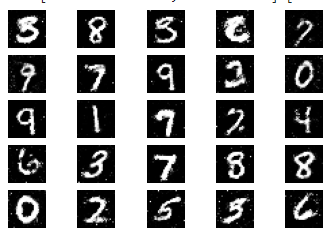

## 1.2 Полносвязный генератор и дискрименатор. Размер скрытого пространства **10**. 

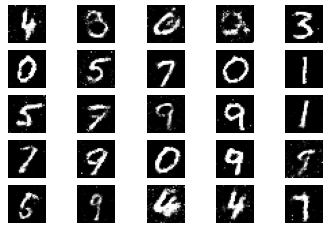

## 1.3 Полносвязный генератор и дискрименатор. Размер скрытого пространства **1000**.

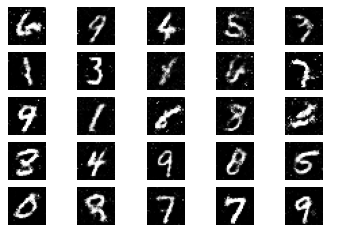

## 2.1 Сверточный генератор и полносвязный дискриминатор. Размер скрытого пространства **100**.

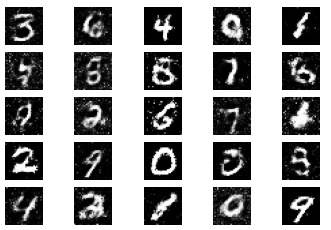



## 2.2 Сверточный генератор и полносвязный дискриминатор. Размер скрытого пространства **10**.

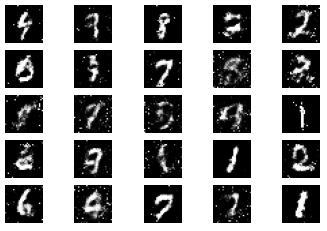



## 2.3 Сверточный генератор и полносвязный дискриминатор. Размер скрытого пространства **1000**.

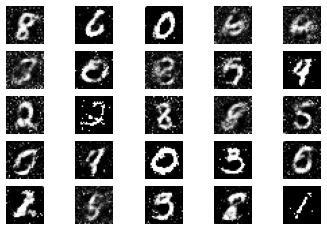

## 3.1 Полносвязные генератор и дискрименатор с разными batch_size(128,256). Размер скрытого пространства **100**.

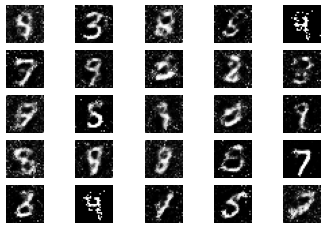

## 3.2 Полносвязные генератор и дискрименатор с разными batch_size(128,256). Размер скрытого пространства **10**.

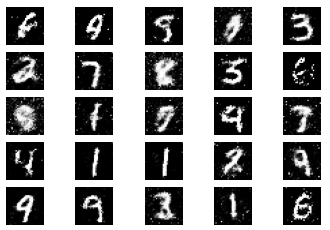

3.3 Полносвязные генератор и дискрименатор с разными batch_size(128,256). Размер скрытого пространства **1000**.

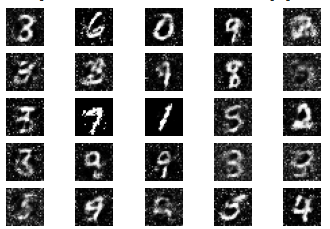

# Выводы:

1. В данной домашней работе было проведено три эксперимента:
 - Полносвязные генератор и дискрименатор
 - Сверточный генератор и полносвязный дискриминатор
 - Полносвязные генератор и дискрименатор с разными **batch_size**(128,256)

2. Во всех экспериментах использовался разный размер скрытого пространства:
   - 100
   - 10
   - 1000

3. Количество эпох обучения одинакого. Архитектура сети и гиперпарамептры тоже.
4. Исходя из полученных данных можно сказать:
 - Лучше всех результат получился у полносвязных генератора и дискриминитора.Вероятно они лучше согласованы. 
 - Сверточная сеть показала результат хуже.
 - Применение разного **batch_size** для обучения не дало улучшения результата.

5. Для наилучшего результата нужно правильно подбирать архитектуры генератора и дискриминатора.  
